In [31]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import os
import cv2
import math
from PIL import Image

from Depth_Model.predict import predict as dep_pred
from PlanarReconstruction.predict import predict as sem_pred

## Set up directories

In [32]:
# im_path = './Images/1594AsterCt/'
# im_name = '924529_18_0.jpg'

im_path = './Images/8100EUnionAve/'
im_name = '03.jpg' #'03.jpg' 

# im_path = './Images/' 
# im_name = 'test_square_2.jpg' 

# im_path = './Images/2855RockCreekCir/' 
# im_name = '8955264_8_0.jpg' 

# im_path = './Images/Apt/' 
# im_name = '4.jpg' 


save_path = './Processed/' + im_name[:-4] 

save_filepath = save_path + '/' + im_name[:-4] 
filepath = im_path + im_name

if not os.path.exists(save_path):
    os.mkdir(save_path)

## The original image

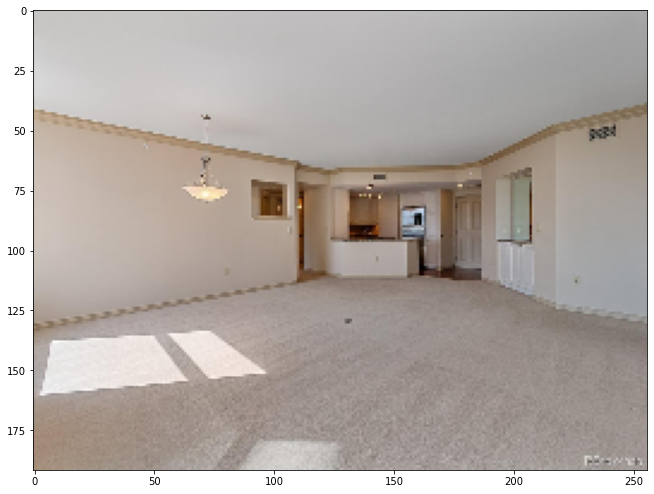

In [33]:
img = cv2.imread(filepath)
rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
rgb_img = cv2.resize(rgb_img, (256, 192))

fig, ax = plt.subplots(1,1)
fig.tight_layout()
fig.set_size_inches(13.5, 7.5)
ax.imshow(rgb_img)

In [34]:
dep_pred('./Depth_Model/NYU_FCRN.ckpt',
         filepath,
         save_filepath,
        )

Loading the model
INFO:tensorflow:Restoring parameters from ./Depth_Model/NYU_FCRN.ckpt


In [35]:
#dep_rgb_im = np.load(save_filepath + '_depth.npy').squeeze()

#print('Max distance is: ', dep_rgb_im.max())

## Use PlanarReconstruction CNN to process image

In [36]:
sem_pred(filepath,
         save_filepath,
        )

C:\Users\Dillo\anaconda3\envs\RoomPersp\lib\site-packages\torch\nn\functional.py:2506: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


## Display surface segmentation and depth images

(1, 128, 160, 1)


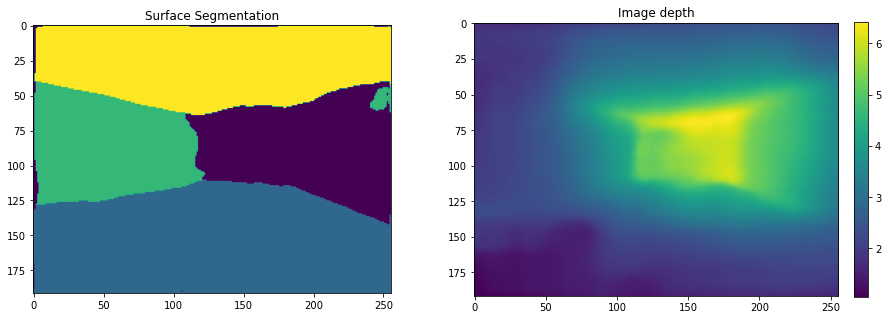

In [37]:
seg = np.load(save_filepath + '_segmentation.npy')
dep2 = np.load(save_filepath + '_depth.npy')
print(dep2.shape)
dep2 = cv2.resize(dep2.squeeze(), (256, 192))

fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [1, 1.1]})

ax1.imshow(seg)
depimg = ax2.imshow( dep2 )
fig.colorbar(depimg,fraction=0.035, pad=0.04)

ax1.set_title('Surface Segmentation')
ax2.set_title('Image depth')

fig.tight_layout()
fig.set_size_inches(13.5, 7.5)
plt.show()

## Extract surface boundaries

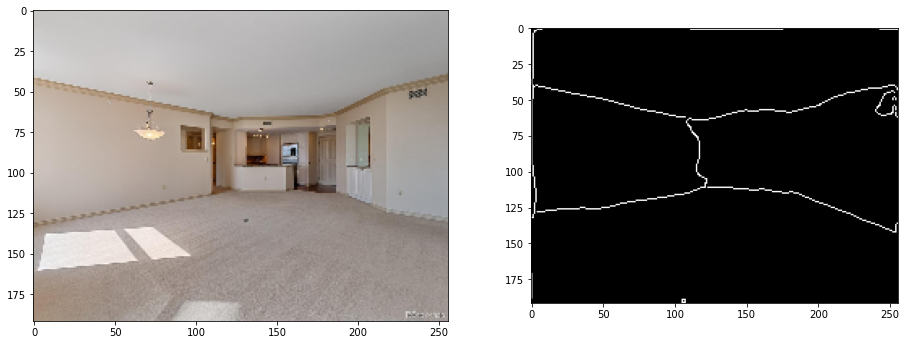

In [38]:
seg = seg.astype(np.uint8)
edges = cv2.Canny(seg, 0, 0)

fig, (ax1, ax2) = plt.subplots(1,2, gridspec_kw={'width_ratios': [1.13, 1.]})
ax1.imshow(rgb_img)
ax2.imshow(edges,cmap = 'gray')

fig.tight_layout()
fig.set_size_inches(13.5, 7.5)
plt.show()

## Remove boundary from edges-image and convert remaining edges in to coordinate-pairs for further analysis.

Many images contain artifacts near the edges that have the tendancy to confound the procedure. Here I make the assumption that all images are framed in such a way that all points of interest happen away from the edges.

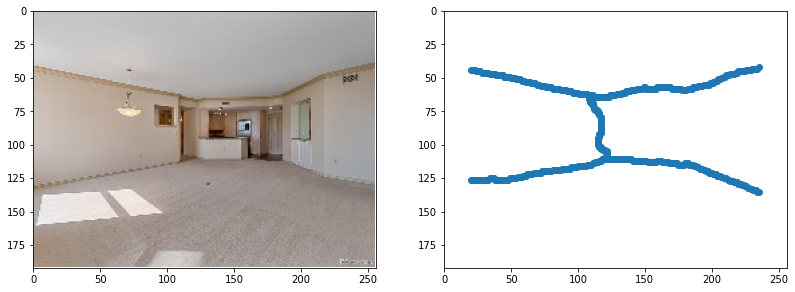

In [39]:
# Strip edges from photo, which often have artifacts
def strip_edge(array, strip_size = 5):
    return array[strip_size:-strip_size ,strip_size:-strip_size ]

# Extract coords of all points.
def extract_coords(edges_array, strip_size = 5):
    
    edges_stripped = strip_edge(edges_array, strip_size)
    shape = edges_stripped.shape
    
    unique, counts = np.unique(edges_stripped, return_counts=True)
    counts_dict = dict(zip(unique, counts))
    num_points = counts_dict[255]
    
    coords = np.zeros([num_points,2])
    
    idx = 0
    for i in range(shape[0]):
        for j in range(shape[1]):
            if edges_stripped[i,j] == 255:
                coords[idx,:] = [j + strip_size, i + strip_size]
                idx += 1
    
    return coords

coords = extract_coords(edges, 20)

fig, (ax1, ax2) = plt.subplots(1,2)

ax2.scatter(coords[:,0], coords[:,1])
ax2.set_xlim([0,256])
ax2.set_ylim([0,192])
ax2.invert_yaxis()
ax2.set_aspect('equal', adjustable='box')

ax1.imshow(rgb_img)
ax1.set_xlim([0,256])
ax1.set_ylim([0,192])
ax1.invert_yaxis()
ax1.set_aspect('equal', adjustable='box')

fig.set_size_inches(13.5, 7.5)
plt.show()

## Compute the distance between every pair of points

For use in finding nearest-neighbors.

In [40]:
# Build matrix containing distance between coords. 
# The i,j-th entrance is the image-pixel-distance between coordinate i and coordinate j

def coord_distances(coords):
    
    num_coords= len(coords)
    distances = np.zeros([num_coords, num_coords])
    
    x = coords[:,0]
    y = coords[:,1]
    
    delta_x_squared = np.square( x[:,np.newaxis] - x )
    delta_y_squared = np.square( y[:,np.newaxis] - y )  
    
    distances = np.sqrt( delta_x_squared +  delta_y_squared)
    
    return distances

distances = coord_distances(coords)

In [43]:
coords[:10,:]

array([[235.,  42.],
       [230.,  43.],
       [231.,  43.],
       [232.,  43.],
       [233.,  43.],
       [234.,  43.],
       [ 20.,  44.],
       [ 21.,  44.],
       [ 22.,  44.],
       [ 23.,  44.]])

In [42]:
distances[10:20, 235:245].astype(int)

array([[115, 114, 114, 115, 115, 115, 116, 116, 116, 117],
       [116, 115, 115, 116, 116, 116, 117, 117, 117, 118],
       [117, 116, 116, 117, 117, 117, 117, 118, 118, 119],
       [118, 117, 117, 117, 118, 118, 118, 119, 119, 119],
       [ 97,  99,  99,  99, 100, 100, 100, 101, 101, 102],
       [ 96,  98,  98,  98,  99,  99,  99, 100, 100, 101],
       [ 95,  97,  97,  97,  98,  98,  99,  99,  99, 100],
       [ 94,  96,  96,  96,  97,  97,  98,  98,  98,  99],
       [109, 108, 108, 109, 109, 109, 110, 110, 110, 111],
       [110, 109, 109, 110, 110, 110, 111, 111, 111, 112]])

## Find the nearest neighbors for any point

For any coordinate index coord_idx, find the nearest "num_neighbors" points

In [13]:
# Find nearest points of a point, returns their indices
def nearest_neighbors(coords, distances, coord_idx, num_neighbs):
    
    idxs = np.array( [idx for idx in range(len(coords)) ])
    distance_to_idx = distances[coord_idx,:]
    
    distances_indexed = np.stack( (distance_to_idx, idxs), 1)
    sorted_distances = distances_indexed[distances_indexed[:,0].argsort()] 

    return sorted_distances[:num_neighbs+1, 1].astype(int)
    
neighbs = nearest_neighbors(coords, distances, 450, 20)

## Simple 1D linear regressor

In [14]:
def linfit( coord_array ):
    
    N = coord_array.shape[0]
    x = coord_array[:,0]
    y = coord_array[:,1]
    
    num = np.dot(x, y) - x.sum()*y.sum()/N
    denom = np.dot(x, x) - ((x.sum())**2)/N
    
    m = num/denom

    b = ( y.sum() - m*x.sum() )/N
    
    error = (y - (m*x + b))/np.sqrt(N)
    
    return m, b, np.dot(error, error)

## Filter the edges, keeping only those which are approximately linear

For every point along an identified edge fit a line to its nearest neighbors. If that linfit meets a certain error criteria (set by "error_thresh") AND if the line has a slope beneath some max value ("slope_thresh") AND if the point is in the lower portion of the image (max y-value set by "cut_y_val"), then keep that point in play.

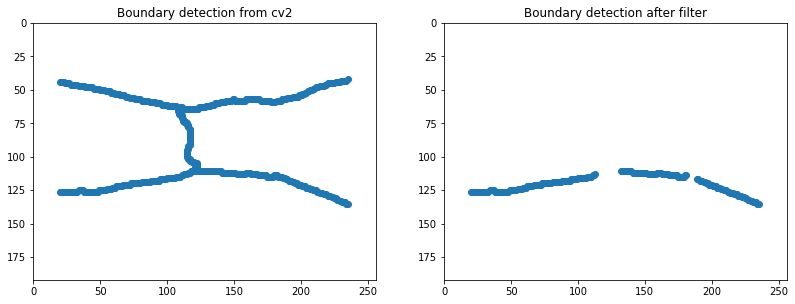

In [15]:
def keep_linear_only(coords, distances, num_neighbors, error_thresh, slope_thresh, cut_y_val):

    linear_regions = []
    for j, coord in enumerate(coords):

        neighbs = nearest_neighbors(coords, distances, j, num_neighbors)
        m, b, e2 = linfit(coords[neighbs])
        if (e2 < error_thresh) and ( abs(m) < slope_thresh ) and (coord[1] > cut_y_val):
            linear_regions.append(coord)
            
    return np.array( linear_regions )

lin_segments =  keep_linear_only(coords, distances, 20, 0.5, 2, 75) 

x_lin_seg = lin_segments[:,0]
y_lin_seg = lin_segments[:,1]

fig, (ax1, ax2) = plt.subplots(1,2)

ax1.scatter(coords[:,0], coords[:,1])
ax1.set_xlim([0,256])
ax1.set_ylim([0,192])
ax1.invert_yaxis()
ax1.set_aspect('equal', adjustable='box')

ax2.scatter(x_lin_seg, y_lin_seg)
ax2.set_xlim([0,256])
ax2.set_ylim([0,192])
ax2.invert_yaxis()
ax2.set_aspect('equal', adjustable='box')

ax1.set_title('Boundary detection from cv2')
ax2.set_title('Boundary detection after filter')

fig.set_size_inches(13.5, 7.5)
plt.show()

## Cluster the linear segments

Operating under the assumption that all floorplans can be described by an n-gon for some (unkown) value n, identify those linear segements nearby one another

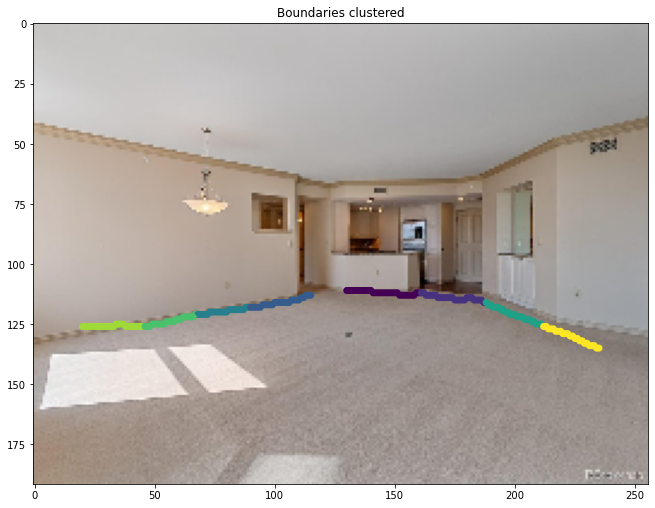

In [16]:
num_neighbors = 22
error_thresh = 1.5
slope_thresh = 10
cut_y_val = 110

lins = keep_linear_only(coords,
                        distances,
                        num_neighbors,
                        error_thresh,
                        slope_thresh,
                        cut_y_val,
                        )

from sklearn.cluster import AffinityPropagation, MeanShift
clusters = AffinityPropagation(random_state = 42,
                               damping = 0.8,
                              ).fit_predict(lins)
#clusters = MeanShift().fit_predict(lins)

x = lins[:,0]
y = lins[:,1]

fig, (ax1) = plt.subplots(1,1)
ax1.imshow(rgb_img)
ax1.scatter(x, y, c = clusters)

#ax2.invert_yaxis()
fig.tight_layout()
fig.set_size_inches(13.5, 7.5)
plt.gca().set_title('Boundaries clustered')
plt.show()

## Interpolate each cluster and identify intersections

Each cluster of points is fitted to a line, this line is extended in either direction until it either encounters the image boundary or the next line. This process runs from left to right.

In [17]:
lin_segs = {}
for cluster in np.unique(clusters):
    lin_segs[cluster] = {}
    
    mask = clusters == cluster
    lin_segs[cluster]['coords'] = lins[mask,:]
    lin_segs[cluster]['min_x'] = lins[mask,0].min()
    
    m, b, e2 = linfit(lins[mask,:])
    lin_segs[cluster]['slope'] = m
    lin_segs[cluster]['y_int'] = b
    
min_x_vals = np.array([(cluster, lin_segs[cluster]['min_x']) for cluster in lin_segs])
min_x_vals_sorted = min_x_vals[min_x_vals[:,1].argsort()]


joined_coords = []
x_left = 0
for k, cluster in enumerate(min_x_vals_sorted[:,0]):
    if not k == len(lin_segs)-1:
        b_left  = lin_segs[min_x_vals_sorted[ k,0 ]]['y_int']
        b_right = lin_segs[min_x_vals_sorted[k+1,0]]['y_int']
        m_left  = lin_segs[min_x_vals_sorted[ k,0 ]]['slope']
        m_right = lin_segs[min_x_vals_sorted[k+1,0]]['slope']       
        
        x_intersect = (b_right - b_left)/(m_left - m_right)
    else:
        b_left  = lin_segs[min_x_vals_sorted[ k,0 ]]['y_int']
        m_left  = lin_segs[min_x_vals_sorted[ k,0 ]]['slope']       
        
        x_intersect = 256
    
    if x_intersect <= x_left:
        x_intersect = x_left
    print(x_left, x_intersect)
    x_vals = np.arange(x_left, x_intersect, 0.25)
    
    joined_coords += [( x, m_left*x + b_left ) for x in x_vals if (m_left*x+b_left < 192) and (m_left*x+b_left > 0)]
    
    x_left = x_intersect
    
joined_coords = np.array(joined_coords)

0 48.258461233682276
48.258461233682276 68.07228915662654
68.07228915662654 94.51954301754041
94.51954301754041 128.45442331023833
128.45442331023833 171.2770350159165
171.2770350159165 184.74266437345997
184.74266437345997 220.25454545454548
220.25454545454548 256


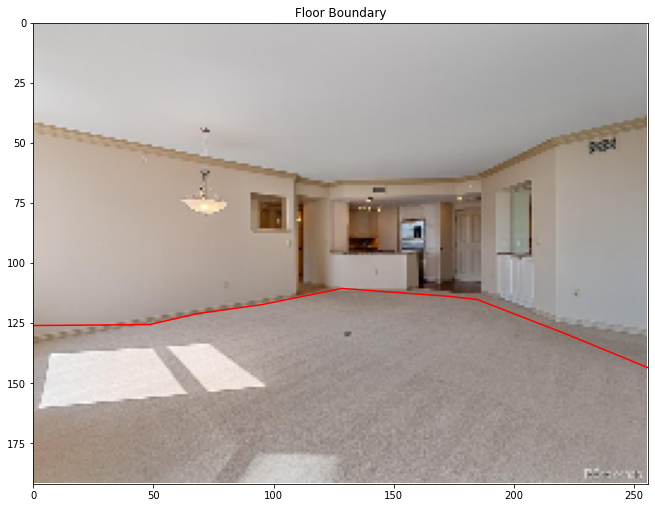

In [18]:
x = joined_coords[:,0]
y = joined_coords[:,1]

fig, (ax1) = plt.subplots(1,1)
ax1.imshow(rgb_img)
#ax1.scatter(x, y)
ax1.plot(x,y, c = 'r')

fig.tight_layout()
fig.set_size_inches(13.5, 7.5)
plt.gca().set_title('Floor Boundary')
ax1.set_xlim([0,256])
ax1.set_ylim([0,192])
ax1.invert_yaxis()
plt.show()

## Map depth information to room boundary

In [19]:
floor_depth = np.zeros( [joined_coords.shape[0], 1] )
avg_rad = 10

for k in range( floor_depth.shape[0] ) :

    x = round( joined_coords[k,0] )
    y = round( joined_coords[k,1] )
    
    if x == 0:
        x = 1
    elif x == 256:
        x = 255
    
    if y == 0:
        y = 1
    elif y == 192:
        y = 191
        
    rad_x = min(x, 256-x, avg_rad)
    rad_y = min(y, 192-y, avg_rad)
    floor_depth[k] = np.mean( dep2[y-rad_y : y+rad_y, x-rad_x : x+rad_x] )

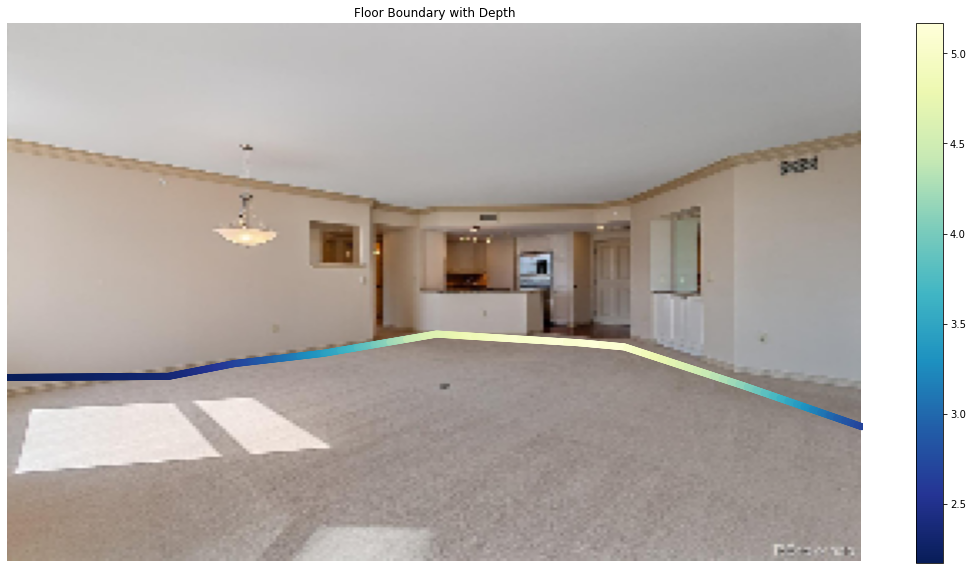

In [20]:
x = joined_coords[:,0]
y = joined_coords[:,1]

fig, (ax1) = plt.subplots(1,1)

ax1.imshow(rgb_img)
a = ax1.scatter(x,y, c = floor_depth, cmap = 'YlGnBu_r')

plt.axis('off')
fig.set_size_inches(13.5, 7.5)
fig.tight_layout()

fig.subplots_adjust(left=0,right=1.1,bottom=0,top=1)


plt.savefig( save_filepath + '.jpg' )

plt.gca().set_title('Floor Boundary with Depth')
ax1.set_xlim([0,256])
ax1.set_ylim([0,192])
plt.colorbar(a)
ax1.invert_yaxis()


plt.show()

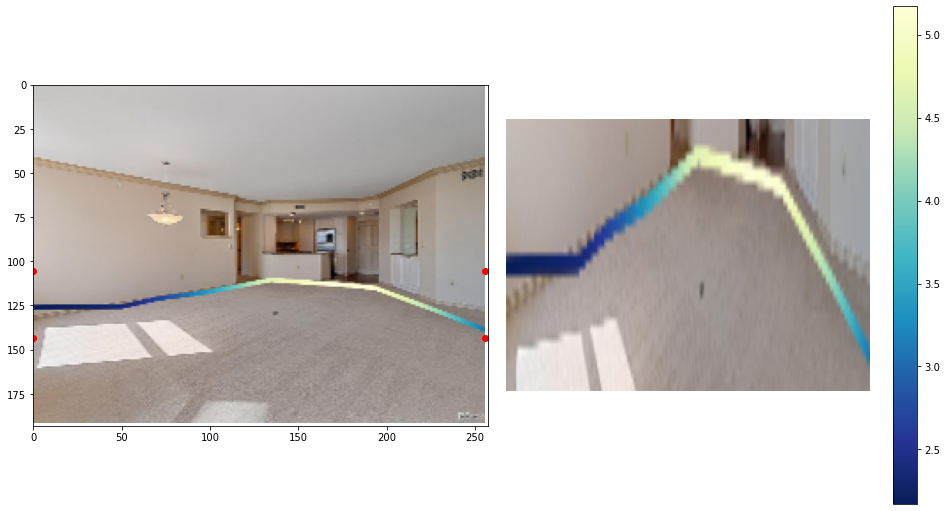

In [21]:
def source_corners(joined_coords):
    
    x = joined_coords[:,0]
    y = joined_coords[:,1]
    
    tl = [ max(0,x.min()), y.min()-5]
    #tl = [0, y.min()]
    tr = [min(256,x.max()), y.min()-5]
    #tr = [256, y.min()]
    bl = [x.min(), y.max()]
    #bl = [0, 192]
    br = [min(256,x.max()), y.max()]
    #br = [256, 192]
    
    return np.array( [tl, tr, br, bl], np.float32 )

def target_corners():
    
#     tl = [0, 600]
#     tr = [500, 600]
#     br = [500, 0]
#     bl = [0, 0]

    tl = [0, 0]
    tr = [256, 0]
    br = [256, 192]
    bl = [0, 192]
    
    return np.array( [tl, tr, br, bl], np.float32 )

src_pts = source_corners(joined_coords)
dst_pts = target_corners()

out_shape = (256, 192)

img_to_warp = cv2.imread(save_filepath + '.jpg')
img_to_warp = cv2.cvtColor(img_to_warp, cv2.COLOR_BGR2RGB)
img_to_warp = cv2.resize(img_to_warp, (256,192))
matrix = cv2.getPerspectiveTransform(src_pts, dst_pts)
result = cv2.warpPerspective(img_to_warp, matrix, out_shape) 

fig, (ax1, ax2) = plt.subplots(1,2)

plt.axis('off')
fig.set_size_inches(13.5, 7.5)
fig.tight_layout()

ax1.imshow(img_to_warp)
ax1.scatter(src_pts[:,0], src_pts[:,1], c='r')

#plt.gca().set_title('Floor Boundary with Depth')
ax1.set_xlim([0,257])
ax1.set_ylim([0,193])
plt.colorbar(a)
ax1.invert_yaxis()


ax2.imshow(result)


In [22]:
rough_bound = np.around(joined_coords).astype(int)
rough_coords = [(rough_bound[k,0], rough_bound[k,1]) for k in range(len(rough_bound))]

bound_img = np.zeros( [192, 256] )

for coord in rough_coords:
    x = coord[0]
    y = coord[1]
    
    if x == 0:
        x = 1
    elif x >= 256:
        x = 255
    
    if y == 0:
        y = 1
    elif y == 192:
        y = 191
        
    bound_img[y,x] = 1

# for j in range(192):
#     for k in range(256):
#         if (k,j) in rough_coords:
#             bound_img[j,k] = 1


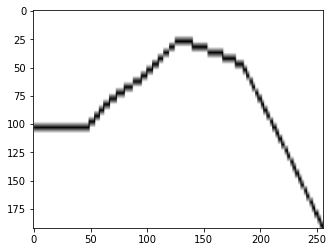

In [23]:
room_bound = cv2.warpPerspective(bound_img, matrix, out_shape)
plt.imshow(room_bound, cmap='gray_r')

In [24]:
from lmfit import Model

# use your same model function
def trapezoid(x, m1, b1, m2, m3, tau1, tau2):
    
    y = np.zeros(len(x))
    m1 = -np.abs(m1)
    m3 = np.abs(m3)
    
    x_idx_tau1 = np.abs( x - tau1 ).argmin()
    x_idx_tau2 = np.abs( x - tau2 ).argmin()
    
    y[:x_idx_tau1] =  m1*x[:x_idx_tau1] + b1
    y[x_idx_tau1:x_idx_tau2] = m2*x[x_idx_tau1:x_idx_tau2] + (m1-m2)*tau1 + b1  #a*tau1 + b 
    y[x_idx_tau2:] = m3*x[x_idx_tau2:] + (m1-m2)*tau1 + (m2-m3)*tau2 + b1
    
    return y

# turn model function into lmfit Model
tmod = Model(trapezoid)

# create Parameters for this model: they will be *named* according
# to the signature of the model function, and be used as keys in
# an ordered-directory-derived object.  Here you can also give
# initial values
params = tmod.make_params(m1=-1, m2=0, m3=1, b1=200, tau1=75, tau2=175)

# now you can set bounds or constraints.  

# 1st, add a new variable "taudiff"
# params.add('taudiff', value=0.1, min=0, vary=True)

# # constraint tau2 to be taudiff+tau1 -- this is no longer a "free variable:
# params['tau2'].expr = "taudiff + tau1"




In [25]:
x = joined_coords[:,0]
y = joined_coords[:,1]

# now do fit to data:
result = tmod.fit(y, params, x=x)

# print report of fit
print(result.fit_report())

[[Model]]
    Model(trapezoid)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 87
    # data points      = 1028
    # variables        = 6
    chi-square         = 1766.90227
    reduced chi-square = 1.72886719
    Akaike info crit   = 568.777874
    Bayesian info crit = 598.390096
[[Variables]]
    m1:   -0.00820545 +/- 0.01065463 (129.85%) (init = -1)
    b1:    126.112826 +/- 0.21876062 (0.17%) (init = 200)
    m2:   -0.13663112 +/- 0.00162635 (1.19%) (init = 0)
    m3:    0.34886851 +/- 0.00244294 (0.70%) (init = 1)
    tau1:  35.6743907 +/- 1.94309262 (5.45%) (init = 75)
    tau2:  160.585090 +/- 0.36757360 (0.23%) (init = 175)
[[Correlations]] (unreported correlations are < 0.100)
    C(m1, b1)     = -0.865
    C(m1, tau1)   = -0.765
    C(m3, tau2)   =  0.652
    C(m2, tau2)   =  0.571
    C(b1, tau1)   =  0.440
    C(m2, tau1)   = -0.406
    C(tau1, tau2) = -0.154


In [26]:
x = joined_coords[:,0]
y = joined_coords[:,1]

m1 = -3.05263158
b1 = 244.947368
m2 = -0.21984692
m3 = 0.45150092
tau1 = 27.8904273
tau2 = 150.444449

y_trap = np.zeros(len(x))


x_idx_tau1 = np.abs( x - tau1 ).argmin()
x_idx_tau2 = np.abs( x - tau2 ).argmin()

y_trap[:x_idx_tau1] =  m1*x[:x_idx_tau1] + b1
y_trap[x_idx_tau1:x_idx_tau2] = m2*x[x_idx_tau1:x_idx_tau2] + (m1-m2)*tau1 + b1  #a*tau1 + b 
y_trap[x_idx_tau2:] = m3*x[x_idx_tau2:] + (m1-m2)*tau1 + (m2-m3)*tau2 + b1


x = joined_coords[:,0]
y = joined_coords[:,1]

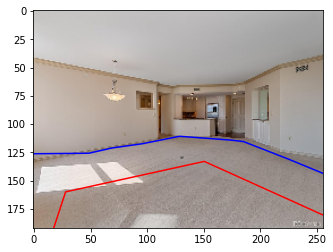

In [27]:
fig, ax = plt.subplots(1,1)
ax.plot(x, y_trap, 'r')
ax.plot(x, y, 'b')
ax.invert_yaxis()
ax.imshow(rgb_img)

In [28]:
k = np.array( [ [1,2,3,4], [3,4,5,6], [3,5,9,11] ] )
k

array([[ 1,  2,  3,  4],
       [ 3,  4,  5,  6],
       [ 3,  5,  9, 11]])

In [29]:
bool_array = np.where( k == 4)
row_vals = bool_array[0]
col_vals = bool_array[1]
num_points = col_vals.shape[0]

# Initialize array that will hold (x,y) coordinates of all edge pixels.
coords = np.zeros([num_points, 2])


for idx in range(num_points):
    point = [ row_vals[idx], col_vals[idx] ]
    coords[idx, :] = point

In [30]:
coords

array([[0., 3.],
       [1., 1.]])